In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.spatial import KDTree
from scipy.optimize import fsolve
from scipy.stats import nbinom
from scipy.special import beta as BF
from scipy import stats

## Load data

6 cell types
14 regions


<Figure size 432x288 with 0 Axes>

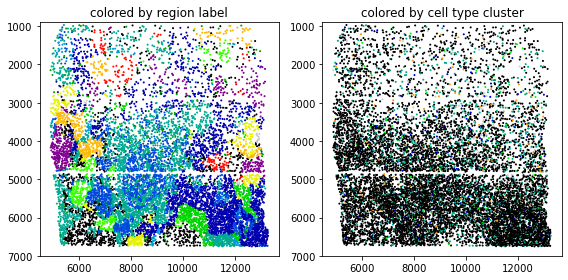

In [2]:
dataset_ID = 'E2' #C1, D1, E2
dataset_path = '../data/CN21_' + dataset_ID + '_cell_types.tsv'
df = pd.read_csv(dataset_path)
#df.head()
cell_type_names = df['cell_type'].unique()
n_cell_types = len(cell_type_names)
cell_type_name_id_dict = dict(zip(cell_type_names, np.arange(0, n_cell_types).astype(int)))
reg_names = df['poly.ID'].unique()
n_regions = len(reg_names)
reg_name_id_dict = dict(zip(reg_names, np.arange(0, n_regions)))
print("%s cell types" % n_cell_types)
print("%s regions" % n_regions)
cmap = cm.get_cmap('nipy_spectral', n_cell_types)

color_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    #print(colors.rgb2hex(rgb))
    color_list.append(colors.rgb2hex(rgb))

type_color_dict = dict(zip(cell_type_names, color_list))


cmap = cm.get_cmap('nipy_spectral', n_regions)

color_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    #print(colors.rgb2hex(rgb))
    color_list.append(colors.rgb2hex(rgb))

reg_color_dict = dict(zip(reg_names, color_list))

df['cell_type_id'] = df['cell_type'].apply(lambda x: cell_type_name_id_dict[x])
df['region_id'] = df['poly.ID'].apply(lambda x: reg_name_id_dict[x])
df['cell_type_color'] = df['cell_type'].apply(lambda x: type_color_dict[x])
df['reg_color'] = df['poly.ID'].apply(lambda x: reg_color_dict[x])

plt.clf()
fix, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.scatter(df['segment_px_x'], df['segment_px_y'], color=df['reg_color'], marker='o', s=1)
ax1.set_title('colored by region label')
ax1.set_ylim(7000,900)
ax2.scatter(df['segment_px_x'], df['segment_px_y'], color=df['cell_type_color'], marker='o', s=1)
ax2.set_title('colored by cell type cluster')
ax2.set_ylim(7000,900)
#plt.gca().invert_yaxis()
plt.savefig('../fig/full_data_region_type_sidebyside.pdf')
plt.tight_layout()
plt.show()

In [3]:
df.head()

,bc,segment_id,segment_px_x,segment_px_y,cell_type,poly.ID,cell_type_id,region_id,cell_type_color,reg_color
1,1000x17,7622,9286.251723,1112.430409,epithelial,Fatty tissue,0,0,#000000,#000000
2,1000x175,16386,9287.929553,2254.195876,endothelial,Fatty tissue;Fibrous tissue;Invasive cancer;im...,1,1,#0000dd,#800091
3,1000x254,21270,9262.589988,2831.436234,epithelial,Fibrous tissue;Invasive cancer;immune/lymphoid,0,2,#000000,#0000ae
4,1000x287,23836,9273.606853,3098.420198,stroma,Fibrous tissue;Invasive cancer;immune/lymphoid,2,2,#00aa88,#0000ae
5,1000x313,25182,9278.407143,3253.669481,epithelial,Invasive cancer,0,3,#000000,#0049dd


In [4]:
ypx = max(df['segment_px_y']) - min(df['segment_px_y']) 
xpx = max(df['segment_px_x']) - min(df['segment_px_x']) 

In [5]:
spot_res_um = 100 #uM, 100 = visium, 200=st distace between spot centroids
spot_diameter = 55 #um, 55 for visum, 100 for st, this is the circular search radiums
x_dim = 5.7e3
y_dim = 2.4e3
px_per_um = 2.5 #px/um
spot_res_px = spot_res_um * px_per_um
spot_diameter_px = spot_diameter * px_per_um
ratio = np.sqrt(3)/2 # cos(60deg)
n_x = int(np.floor(np.floor(x_dim/spot_res_um)/ratio))
n_y = int(np.floor(y_dim/spot_res_um))


In [6]:
# make hexagonal grid
show_plot = False 

xs = np.arange(min(df['segment_px_x']), max(df['segment_px_x']),spot_res_px)
ys = np.arange(min(df['segment_px_y']), max(df['segment_px_y']),spot_res_px)

xv, yv = np.meshgrid(
            xs, 
            ys, 
            sparse=False, 
            indexing='xy'
            )

#xv = xv*ratio
xv[::2, :] += 0.5 * (xs[1]-xs[0])

if show_plot:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(xv, yv, s=1)
    ax.axis('equal')


In [7]:
bead_x = xv.reshape(-1)
bead_y = yv.reshape(-1)
bead_coords = np.vstack([bead_x, bead_y]).T
cell_coords = df.iloc[:, 2:4].to_numpy()
tree = KDTree(cell_coords)


In [8]:
cell_types_1hot = np.zeros((len(df), max(df['cell_type_id']) + 1), dtype=int)
for i, j in enumerate(df['cell_type_id']):
    cell_types_1hot[i, j] = 1

cell_type_names = ['epithelial', 'endothelial', 'stroma', 'Bcell', 'Tcell', 'macrophage']
df2 = pd.DataFrame(np.hstack([cell_coords, cell_types_1hot]), columns=['x', 'y', 'epithelial', 'endothelial', 'stroma', 'Bcell', 'Tcell', 'macrophage'])


In [9]:
spot_diameter_px

137.5

In [10]:
spot_data = np.zeros((bead_coords.shape[0], n_cell_types))

for i in range(0, bead_coords.shape[0]):
    # for each bead, find cells within that search radius
    r = spot_diameter_px/2
    bead_cells_idx = tree.query_ball_point(bead_coords[i, :], r = r)
    bead_counts = np.sum(cell_types_1hot[bead_cells_idx, :], axis=0)
    spot_data[i, :] = bead_counts

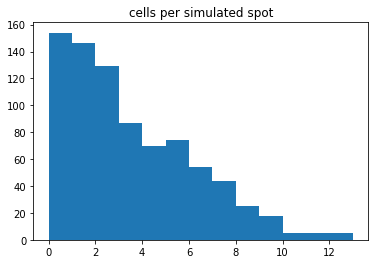

In [11]:
cells_per_spot = np.sum(spot_data, axis=1, dtype=int)
#print(max(cells_per_spot))
plt.hist(cells_per_spot, bins=max(cells_per_spot))
plt.title("cells per simulated spot")
plt.show()

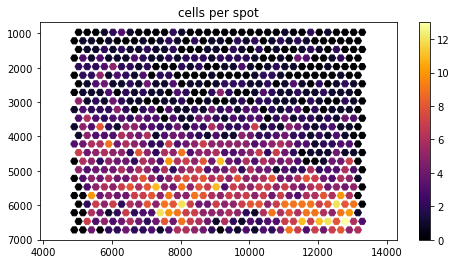

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4))
sc = ax.scatter(bead_coords[:, 0], bead_coords[:, 1], c = cells_per_spot, cmap='inferno', marker='H', s=50)
ax.invert_yaxis()
ax.axis('equal')
plt.colorbar(sc)
plt.title('cells per spot')
#plt.savefig('../fig/visium_sim_cells_per_spot-HDST-BC.pdf')
plt.show()

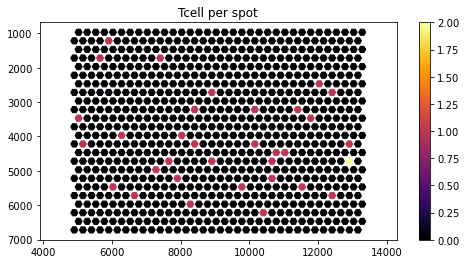

In [13]:
cell_type_names
cell_type = 'Tcell'
cell_type_idx,  = np.where(np.array(cell_type_names) == cell_type)

cell_type_counts_by_spot = spot_data[:, cell_type_idx]

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
sc = ax.scatter(bead_coords[:, 0], bead_coords[:, 1], c = cell_type_counts_by_spot, cmap='inferno', marker='H', s=50)
ax.invert_yaxis()
ax.axis('equal')
plt.colorbar(sc)
plt.title('%s per spot' % cell_type)
#plt.savefig('../fig/visium_sim_%s_per_spot-HDST-BC.pdf' % cell_type)
plt.show()

In [27]:
thresh = 0.1
cells_per_spot_thresh = np.floor(cells_per_spot * thresh)
met_cutoff = (cell_type_counts_by_spot.reshape(-1) > cells_per_spot_thresh)
met_cutoff = met_cutoff.astype(int)

In [28]:
np.unique(met_cutoff, return_counts=True)

(array([0, 1]), array([784,  32]))

In [31]:
#### make new dataframe for binned data for compatability with existing code

threshold = 1 #set how many cells of toi are in a spot for it to be a TOI spot

#simplify to spots that are of the TOI or not, ignore other types:
#toi_ix, = np.where(spot_data[:, cell_type_idx] >= 1)
toi_ix,  = np.where(met_cutoff == 1)
toi_col = np.zeros(spot_data.shape[0])
toi_col[toi_ix] = 1 #if spot toi_col=1, it is a TOI spot

bin_df = pd.DataFrame(np.hstack([bead_coords, 
                      toi_col.reshape(bead_coords.shape[0], 1)]), 
                      columns=['spot_x', 'spot_y', 'toi_spot']
                      )

bin_df.head()

#bin_df.to_csv('../data/D1_binned.csv')


,spot_x,spot_y,toi_spot
0,5033.404467,967.658436,0.0
1,5283.404467,967.658436,0.0
2,5533.404467,967.658436,0.0
3,5783.404467,967.658436,0.0
4,6033.404467,967.658436,0.0


#### Sampling experiments on simulated visium

In [32]:
def calculate_FOV_size(sampling_frac, min_x, max_x, min_y, max_y):
    area = (max_x - min_x) * (max_y - min_y)
    sampling_area = sampling_frac * area
    FOV_dim = np.round(np.sqrt(sampling_area))
    return FOV_dim
    
x_min = min(df['segment_px_x'])
x_max = max(df['segment_px_x'])
y_min = min(df['segment_px_y'])
y_max = max(df['segment_px_y'])

fov_size_05r = calculate_FOV_size(0.005, x_min, x_max, y_min, y_max)
fov_size_1r = calculate_FOV_size(0.01, x_min, x_max, y_min, y_max)
fov_size_5r = calculate_FOV_size(0.05, x_min, x_max, y_min, y_max)
fov_size_75r = calculate_FOV_size(0.075, x_min, x_max, y_min, y_max)
fov_size_10r = calculate_FOV_size(0.10, x_min, x_max, y_min, y_max)

In [33]:
def build_assignment_matrix(attribute_dict, n_cell_types=2):
    #set n_cell_types=2 b/c we have spots that are either toi or not
    data = list(attribute_dict.items())
    data = np.array(data)  # Assignment matrix

    B = np.zeros((data.shape[0], n_cell_types))  # Empty matrix

    for i in range(0, data.shape[0]):
        t = int(data[i, 1])
        B[i, t] = 1

    return B
    
def random_FOV(FOV_dim, df, min_x, max_x, min_y, max_y):
    x_start = np.random.randint(min_x, max_x - FOV_dim)
    y_start = np.random.randint(min_y, max_y - FOV_dim)
    
    x_filtered = df[(df['spot_x'] > x_start) & (df['spot_x'] < x_start + FOV_dim)]
    random_FOV = x_filtered[(x_filtered['spot_y'] > y_start) & (x_filtered['spot_y'] < y_start + FOV_dim)]
    
    return random_FOV

def fov_cell_counts(df, fov_dim, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n = False):
    
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) > 3:
            types_in_fov = fov['toi_spot'].astype(int).tolist()
            #print(types_in_fov)
            attribute_dict = dict(zip(fov.index, types_in_fov))
            B = build_assignment_matrix(attribute_dict, n_cell_types)
            p_list.append(np.sum(B, axis=0))
            ns.append(len(fov))
            i += 1
        else:
            continue
        
    sample_counts = np.vstack(p_list)
    
    if ret_n == True:
        return sample_counts[:, toi].astype(int), np.sum(sample_counts, axis=1).astype(int)
    else:
        return sample_counts[:, toi].astype(int)

In [34]:
toi = cell_type_idx #type of interest
n_fov = 1000 #number of FOVs from which parameters are estimated.

x_min = min(df['segment_px_x'])
x_max = max(df['segment_px_x'])
y_min = min(df['segment_px_y'])
y_max = max(df['segment_px_y'])

n_toi_observed, ns= fov_cell_counts(bin_df, fov_size_05r, 1, n_fov, x_min, x_max, y_min, y_max, n_cell_types=2, ret_n=True )

values, counts = np.unique(n_toi_observed, return_counts=True)

Text(0, 0.5, 'Count')

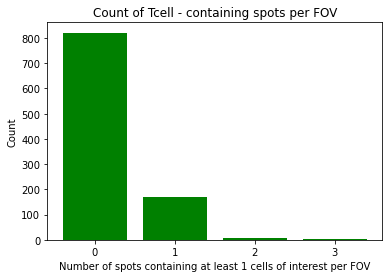

In [35]:
v = np.arange(0, max(values) + 1)
val_count = dict(zip(values, counts))
c = [val_count[i] if i in values else 0 for i in v]
plt.bar(v, c, color='g')
_ = plt.xticks(ticks=v)
plt.xlabel('Number of spots containing at least %s cells of interest per FOV' % threshold)
plt.title('Count of %s - containing spots per FOV' %cell_type)
plt.ylabel('Count')

/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


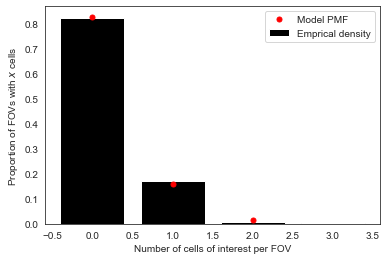

In [36]:
def convert_params(m, k):
    """ 
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    Parameters
    ----------
    m : float 
       Mean
    k : float
       Overdispersion parameter. 
    """
    k = 1/k
    var = m + k * m ** 2
    p = (var - m) / var
    r = m ** 2 / (var - m)
    return r, 1-p
    
v = np.arange(0, max(values) + 1)
val_count = dict(zip(values, counts))
c = np.array([val_count[i] if i in values else 0 for i in v])

n0 = c[0]
N = np.sum(c)
p0 = n0/N
m = np.mean(n_toi_observed)

def f2(k, p0, m):
    return np.power((m/k + 1), -k) - p0

k = fsolve(f2, x0=0.2, args=(p0, m))

r, p = convert_params(m, k[0])

sns.set_style('white')
plt.bar(v, c/n_fov, color='k', label = 'Emprical density')
x = np.arange(nbinom.ppf(1e-5, r, p),
              nbinom.ppf(1-1e-4, r, p))
plt.plot(x, nbinom.pmf(x, r, p), 'ro', ms=5, label='Model PMF')

#_ = plt.xticks(ticks=v)
plt.xlabel('Number of cells of interest per FOV')
plt.ylabel('Proportion of FOVs with $x$ cells')
plt.legend()
#plt.savefig('../fig/empirical_hist_with_model_type' + str(toi) + 'pdf')

In [37]:
def do_model_trials(df, fov_size, toi, n_cell_types, n_fov, n_trials):
    
    x_min = min(df['spot_x'])
    x_max = max(df['spot_x'])
    y_min = min(df['spot_y'])
    y_max = max(df['spot_y'])

    trial_counter = 0
    
    def f2(k, p0, m):
            return np.power((m/k + 1), -k) - p0
        
    ns = np.arange(0,10)
    while trial_counter < n_trials:
        n_toi_observed = fov_cell_counts(df, fov_size, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types)
        values, counts = np.unique(n_toi_observed, return_counts=True)
        v = np.arange(0, max(values) + 1)
        val_count = dict(zip(values, counts))
        c = np.array([val_count[i] if i in values else 0 for i in v])
        
        #Parameter estimation with ZTM method
        n0 = c[0]
        N = np.sum(c)
        p0 = n0/N
        m = np.mean(n_toi_observed)
        k = fsolve(f2, x0=0.2, args=(p0, m))
        r, p = convert_params(m, k[0])
        
        x = np.arange(0, 60)
        if trial_counter == 0:
            res = nbinom.pmf(x, r, p)
            fov = p_discovery_in_n_fov(p0, ns)
        else:
            res = np.vstack((res, nbinom.pmf(x, r, p)))
            fov = np.vstack((fov, p_discovery_in_n_fov(p0, ns)))
        trial_counter += 1 
    
    return res, fov

def p_discovery_in_n_fov(p0, n):
        return 1 - np.power(p0, n)

def calc_errs(arr, ci=0.95):
    means = np.mean(arr, axis = 0)
    std = np.std(arr, axis = 0)
    ci = stats.norm.ppf(0.95) * (std/np.sqrt(arr.shape[0]))
    return means, ci

In [38]:
toi = 1
n_fov = 30 #for estimating the parameters
n_trials = 50 #for CI

res_1r, fov_1r = do_model_trials(bin_df, fov_size=fov_size_1r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)
res_5r, fov_5r = do_model_trials(bin_df, fov_size=fov_size_5r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)
res_05r, fov_05r = do_model_trials(bin_df, fov_size=fov_size_05r, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials)


/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(m

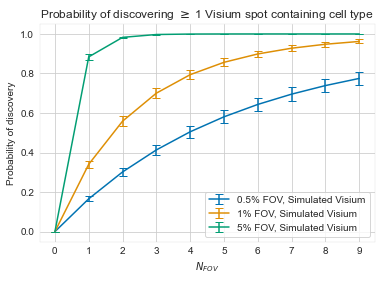

In [39]:
import matplotlib
sns.set_style('whitegrid')

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

labels = ['0.5% FOV, Simulated Visium', '1% FOV, Simulated Visium', '5% FOV, Simulated Visium']
arrs = [fov_05r, fov_1r, fov_5r]
ns = np.arange(0,10)
sns.set_style('whitegrid')
for i in range(0, len(arrs)):
    mean, ci = calc_errs(arrs[i], ci=0.95)

    if i < 4:
        plt.errorbar(ns, mean, yerr=ci, label=labels[i], color = sns.color_palette('colorblind')[i%4], capsize=4)
        
_ = plt.xticks(ticks=ns)
plt.xlabel('$N_{FOV}$')
plt.ylabel('Probability of discovery')
plt.legend()
plt.title('Probability of discovering $\geq$ 1 Visium spot containing cell type')
#plt.tight_layout()
#plt.savefig('../fig/nFOVs_'+str(cell_type)+'discovery_ci95_HDST_E2_simulatedVisium.pdf')
plt.show()


In [40]:
orig_res_05 = np.load('./HDST_RST_0.5FOV.npy')
orig_res_1 = np.load('./HDST_RST_1FOV.npy')
orig_res_5 = np.load('./HDST_RST_5FOV.npy')

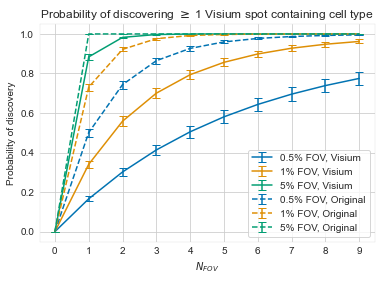

In [41]:
import matplotlib
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})


labels = ['0.5% FOV, Visium', '1% FOV, Visium', '5% FOV, Visium']
arrs = [fov_05r, fov_1r, fov_5r]
ns = np.arange(0,10)
sns.set_style('whitegrid')
for i in range(0, len(arrs)):
    mean, ci = calc_errs(arrs[i], ci=0.95)

    if i < 4:
        plt.errorbar(ns, mean, yerr=ci, label=labels[i], color = sns.color_palette('colorblind')[i%4], capsize=4)

labels = ['0.5% FOV, Original', '1% FOV, Original ', '5% FOV, Original']
arrs = [orig_res_05, orig_res_1, orig_res_5]
ns = np.arange(0,10)
sns.set_style('whitegrid')
for i in range(0, len(arrs)):
    mean, ci = calc_errs(arrs[i], ci=0.95)

    if i < 4:
        plt.errorbar(ns, mean, yerr=ci, label=labels[i], color = sns.color_palette('colorblind')[i%4], capsize=4, linestyle='dashed')

_ = plt.xticks(ticks=ns)
plt.xlabel('$N_{FOV}$')
plt.ylabel('Probability of discovery')
plt.legend()
plt.title('Probability of discovering $\geq$ 1 Visium spot containing cell type')
#plt.tight_layout()
plt.savefig('./nFOVs_'+str(cell_type)+'discovery_ci95_HDST_simulatedVisium_with_original_DeconvolutionError10%.pdf')
plt.show()

In [26]:
pwd

'/Users/ethan/Dropbox (MIT)/Lab/spatial-data-generation_brokengit/circle_packing/breast_cancer_hdst/code'